1. Pakai semua fitur kecuali vin, saledate, (seller)
2. Yang bisa dikategoriin, dikategoriin secara manual (OHE)
3. Hindari penggunaan clustering KModes
4. Pilih cara encoding yang cocok
5. Buat feature extraction yang baru, ngelakuin analisis  
6. Coba diubah scaler nya. StandardScaler, MinMaxScaler.
7. Tidak hapus outliers, pakai RobustScaler.

Aby : Encoding dgn frekuensi  
Yuna : Catboost encoding (split data first)  
Irham : Target encoding  
Ghulam : Hash encoding atau encoding atau cluster(unique value ga terlalu banyak)

Evaluasi (ketika modelling selesai)

1. Feature importance, shap value (fitur2 yg paling berpengaruh)
2. Cross validation (model terbaik)
3. Mengeluarkan nilai sellingprice yg baru
4. Visualisasikan apakah udh sesuai dgn goals kita di awal.
5. dll

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import plotly.express as px
warnings.filterwarnings('ignore')

%matplotlib inline

# Load and Describe Data

---------

## Load Data

Dataset yang kita gunakan adalah "Used Car Auction Prices" yang berasal dari Kaggle

In [47]:
#dfcar = pd.read_csv('https://drive.google.com/uc?id=1KfTnuIeppn-b5bdMyIvVVbII_P7m1Tnu', on_bad_lines="skip")

dfcar = pd.read_csv('car_prices.csv', on_bad_lines= "skip")
dfcar.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.000,16639.000,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.000,9393.000,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.500,1331.000,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


**List fitur pada dataset adalah sebagai berikut :**

1. Year : Tanggal produksi dari mobil.
2. Make : Merk dari mobil.
3. Model : Edisi dari tiap merk mobil.
4. Trim : Versi trim dari mobil.
5. Body : Tipe bentuk dari mobil.
6. Transmission : Transmisi yang digunakan pada mobil.
7. VIN : Vehicle Identification Number.
8. State : Negara bagian tempat mobil dijual.
9. Condition : Kondisi dari mobil pada saat dijual.
10. Odometer : Jarak tempuh mobil semenjak tanggal manufacture.
11. Color : Warna eksterior dari mobil.
12. Interior : Warna interior dari mobil.
13. Seller : Penjual dari mobil (Car dealers).
14. **MMR : Manhiem Market Record, market yang memprediksi harga mobil.**
15. Sellingprice : Nilai jual mobil.
16. Saledate : Tanggal mobil dijual.

## Data Exploration

In [5]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


1. Total dari data ada 558811 entries
2. Tipe dari data int, float dan object, dan terlihat sudah sesuai dengan kolomnya. Namun, untuk kolom `saledate` tipe data yang awalnya 'object', dirasa perlu diubah ke date time.
3. Terdapat nilai Null pada beberapa fitur

In [6]:
# Mengecek null value
dfcar.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65353
vin                 0
state               0
condition       11794
odometer           94
color             749
interior          749
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

Terdapat 9 fitur yang memiliki Null value, yaitu `make`, `model`, `trim`, `body`, `transmission`, `condition`, `odometer`, `color`, `interior`. Perlu diadakan tindak lanjut di Data Cleaning

In [7]:
# Mengecek duplicated rows
dfcar.duplicated().sum()

0

Dataset tidak memiliki data duplikat sehingga tidak diperlukan penanganan.

In [8]:
# Mengkategorikan fitur sesuai dari tipe data
num = ['year', 'condition', 'odometer', 'mmr', 'sellingprice']
cat = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller', 'saledate']

# Membatasi angka setelah koma hingga hanya 3 angka
pd.set_option('display.float_format', lambda x: '%.3f' % x)

dfcar[num].describe()

,year,condition,odometer,mmr,sellingprice
count,558811.000,547017.000,558717.000,558811.000,558811.000
mean,2010.039,3.425,68323.196,13769.325,13611.262
std,3.967,0.949,53397.753,9679.875,9749.657
min,1982.000,1.000,1.000,25.000,1.000
25%,2007.000,2.700,28374.000,7100.000,6900.000
50%,2012.000,3.600,52256.000,12250.000,12100.000
75%,2013.000,4.200,99112.000,18300.000,18200.000
max,2015.000,5.000,999999.000,182000.000,230000.000


1. `condition` memiliki value antara 1-5.
2. Nilai dari `odometer` terlihat memiliki jarak yang jauh antara min dan max dimana nilai min nya adalah 1 dan max nya hampir 1 juta. Tentu ini adalah hal yang terkesan janggal. Selain itu, nilai mean dan median nya juga terhitung sangat jauh yaitu 16000.
3. Secara keseluruhan, nilai `mmr` dan `sellingprice` tidak terlalu berbeda. Namun, nilai min-max dan mean-median nya sangat jauh, sehingga perlu diperhatikan lebih lanjut untuk tahap berikutnya.
4. Beberapa kolom di fitur numerical juga terdapat null value, sehingga perlu ditangani pada tahap berikutnya.

In [9]:
dfcar[cat].describe()

,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,548510,548412,548160,545616,493458,558811,558811,558062,558062,558811,558811
unique,96,973,1975,86,2,550296,38,20,17,14264,3745
top,Ford,Altima,Base,Sedan,automatic,wbanv13588cz57827,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,93554,19349,55817,199437,475914,5,82945,110970,244325,19693,5334


1. Dari data diatas, kita bisa melihat secara sekilas nilai apa yang paling teratas, sering muncul, dan berapa jumlah unique value dari masing-masing fitur.
2. Sebagai contoh, Ford merupakan `make` yang paling populer diantara 96 total brand lain. Selain itu, mobil `body` sedan juga termasuk yang paling favorit.
3. `transmission` automatic lebih dicari customer dibanding manual dengan jumlah lebih dari 90%.
4. Warna hitam tetap mendominasi baik di eksterior maupun interior.

----------

# EDA (Exploratory Data Analysis)

-------

## UNIVARIATE ANALYSIS

Pada tahap EDA, kita akan menganalisis baik analisis univariate ataupun multivariate. Pada univariate analysis, kami menganalisis fitur-fitur yang sekiranya memberikan dampak besar terhadap harga jual mobil. Tak hanya itu, kami juga memvisualisasikan bagaimana persebaran data pada dataset baik ditinjau dari outliers, skewness, null value, dll.

### Unique Value From Some Features

In [ ]:
dfcar['year'].unique()

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003, 2002, 2001, 2000, 1999, 1998, 1995, 1996, 1997, 1987,
       1994, 1993, 1992, 1989, 1991, 1990, 1986, 1985, 1988, 1984, 1982,
       1983])

Semua value sudah sesuai, yaitu berupa angka yang dimulai dari tahun 1982 hingga 2015.

In [ ]:
dfcar['make'].unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', nan, 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

Terdapat null value pada fitur `make`.
Value dari kolom `make` masih terlalu beragam dimana terdapat kata yang huruf awal kapital, kata yang berisi kapital semua, kata yang berisi lower case semua. Oleh karena itu, kita akan mengubah value nya menjadi lower case semua di tahap berikutnya. Hal yang sama mungkin saja juga terjadi pada fitur tipe obejct lainnya.

In [ ]:
dfcar['trim'].unique()

array(['LX', '328i SULEV', 'T5', ..., 'pure', 'EWB', 'Power Wagon'],
      dtype=object)

Fitur `trim` memiliki lebih dari 1000 values sehingga unique value yang muncul hanya beberapa.

In [ ]:
dfcar['condition'].unique()

array([5. , 4.5, 4.1, 4.3, 1. , 3.4, 2. , 4.2, 3. , 4.8, nan, 4.9, 1.7,
       1.9, 2.9, 3.8, 4.4, 4.7, 3.2, 4. , 2.5, 3.7, 3.9, 3.1, 2.8, 4.6,
       3.6, 3.5, 2.6, 2.1, 2.2, 2.7, 2.4, 3.3, 2.3, 1.5, 1.6, 1.8, 1.2,
       1.4, 1.1, 1.3])

Untuk kondisi mobil bervariasi dari 1 sampai 5, serta terdapat null value.

### Outlier Numerik (year, condition, odometer, MMR, sellingprice)

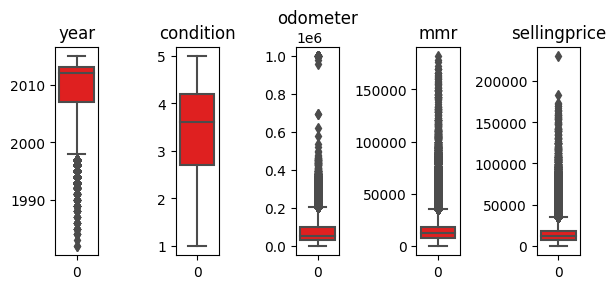

In [ ]:
# Melihat penampilan outlier

plt.figure(figsize=(6, 3))
for i in range(0, len(num)):
    plt.subplot(1, len(num), i+1)
    sns.boxplot(dfcar[num[i]], color='red', orient='v')
    plt.title(num[i])
    plt.tight_layout()

Dapat dilihat bahwa `mmr` dan `selling price` memiliki outlier paling banyak, begitu juga dengan kolom odometer dan year. Untuk kuartil dan mediannya pun juga terkesan jauh. Hal ini dapat terjadi karena banyaknya data mobil (500k++) sehingga nilai mmr dan selling price mapun odometer juga sangat bervariasi. Kolom yang terlihat paling normal hanyalah kolom 'condition'. Hasil analisis ini merupakan bentuk visual dari statistik data yang telah kita lakukan sebelumnya pada tahap Data Exploration.

### Distribusi Data (year, condition, odometer, MMR, sellingprice)

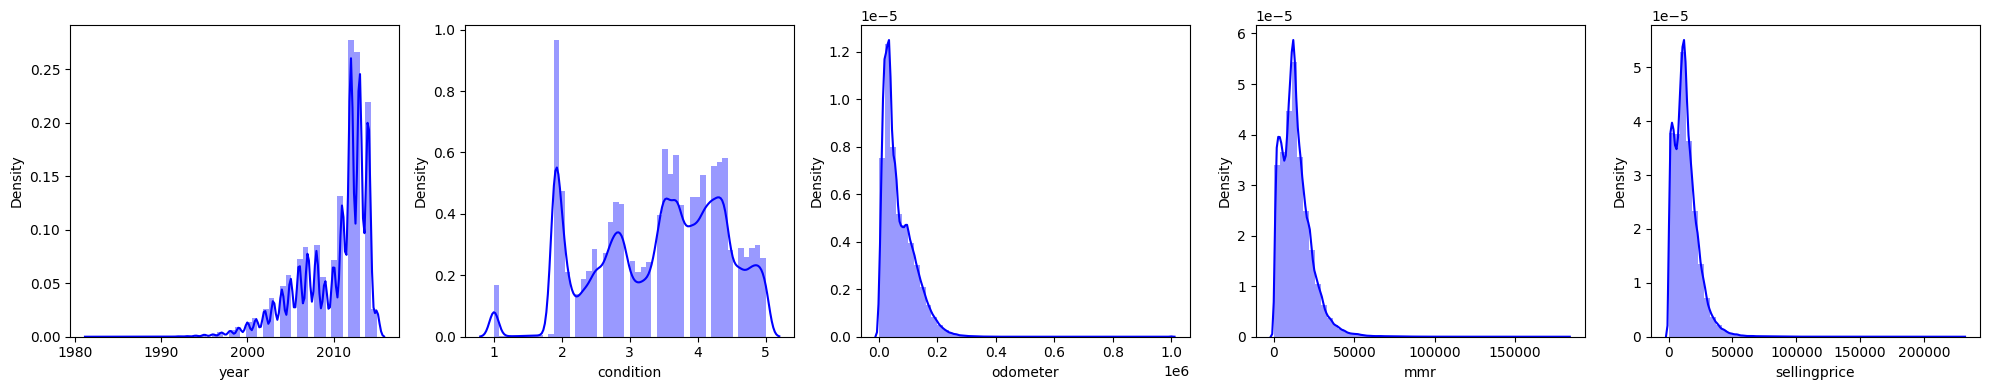

In [ ]:
# Melihat grafik distribusi

plt.figure(figsize=(20, 4))
for i in range(0, len(num)):
    plt.subplot(1, 5, i+1)
    sns.distplot(dfcar[num[i]], color='blue')
    plt.tight_layout()

Dari grafik diatas dapat terlihat :
1. Dari kolom `year` kita bisa melihat bahwa penjualan cenderung mengalami peningkatan pada setiap tahunnya dan puncak penjualan berada di antara tahun 2010 hingga 2015. Kita juga bisa melihat bahwa kolom `year` termasuk left-skewed.
2. Pada grafik `condition`, kondisi mobil yang berada di kisaran angka 2 menjadi mayoritas dari kondisi lainnya. Hal ini menunjukkan bahwa kondisi mobil bekas bernilai kurang baik. Namun, tidak sedikit juga kondisi mobil yang bernilai 3 keatas hingga 4.
3. Untuk `odometer` dapat terlihat bahwa mayoritas berada di angka 0 hingga 0.2 yang artinya odometer berkisar antara 0 hingga 200k. Sedangkan untuk pemakaian mobil diatas 200k terhitung jarang.
4. Kolom `mmr` dan `sellingprice` terlihat serupa dimana harga jual mobil berkisar di angka 0-50000.
5. Dari kolom-kolom diatas, kolom `odometer`, `mmr`, dan `sellingprice` termasuk right-skewed.

### Check Nilai Min dan Max

Seperti analisis sebelumnya dimana kita menemukan nilai min dan max yang terkesan tidak masuk akal, maka kita akan mengecek lebih lanjut data yang mengandung nilai tersebut.  

Beberapa kolom tersebut adalah 'odometer', 'mmr', dan 'sellingprice'.

**1. Nilai min dan max dari kolom Odometer**

In [ ]:
min_odo = dfcar[dfcar['odometer'] == 1.000]
min_odo.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
58763,2005,Chevrolet,Cobalt,LS,Sedan,manual,1g1al54f857551985,md,3.400,1.000,green,gray,purple heart services inc,4375,225,Tue Jun 23 2015 02:30:00 GMT-0700 (PDT)
246325,2001,Volvo,S60,T5,Sedan,automatic,yv1rs53d012002439,oh,1.000,1.000,black,gray,titlemax/whitehall oh1,2950,600,Tue Feb 17 2015 05:00:00 GMT-0800 (PST)
380877,2013,Toyota,RAV4,LE,SUV,automatic,2t3bfrev0dw048471,ut,1.000,1.000,red,black,hertz/tra,19550,3200,Wed Mar 04 2015 04:30:00 GMT-0800 (PST)


In [ ]:
max_odo = dfcar[dfcar['odometer'] == 999999.000]
max_odo.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
398167,2003,Mercedes-Benz,C-Class,C240,Sedan,automatic,wdbrf61j33f350593,ca,2.200,999999.000,silver,gray,800 loan mart,850,1500,Thu Mar 05 2015 04:00:00 GMT-0800 (PST)
385721,2014,Kia,Forte,EX,Sedan,automatic,knafx4a8xe5052180,tx,1.000,999999.000,black,black,kia motors finance,11300,3100,Tue Mar 03 2015 02:30:00 GMT-0800 (PST)
13568,2009,Dodge,Charger,Base,Sedan,automatic,2b3ka43dx9h521300,tx,1.000,999999.000,blue,black,santander consumer,4150,5500,Thu Jan 08 2015 14:10:00 GMT-0800 (PST)


Dari data min dan max kolom 'odometer' diatas terlihat bahwa data tersebut tidak hanya mengandung nilai min dan max yang jauh tetapi pada kolom lain juga tidak normal. Hal tersebut bisa dilihat dari sample diatas dimana baris min dan max tersebut juga banyak mengandung null value, nilai mmr dan selling price yang rendah, dan kondisi yang tidak bagus.

**2. Nilai Min Selling Price**

In [ ]:
min_price = dfcar[dfcar['sellingprice'] == 1.000]
min_price.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
348252,1995,Isuzu,Rodeo,LS,SUV,NaN,4s2cm58v9s4375559,va,1.000,254132.000,red,gray,automotive remarketing inc,375,1,Wed Mar 04 2015 01:05:00 GMT-0800 (PST)
48453,2003,Mercedes-Benz,E-Class,E500,Sedan,automatic,wdbuf70j73a269529,ga,2.100,1.000,black,black,peoples credit company inc,7325,1,Tue Jan 06 2015 09:30:00 GMT-0800 (PST)
293223,2014,Ford,E-Series Van,E-250,E-Series Van,automatic,1ftne2ew6eda13643,tx,4.100,31886.000,white,gray,u-haul,20800,1,Thu Feb 12 2015 03:00:00 GMT-0800 (PST)


**3. Nilai Min dari MMR**

In [ ]:
min_mmr = dfcar[dfcar['mmr'] == 25.000]
min_mmr.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
386755,2002,NaN,NaN,NaN,NaN,NaN,kmhcg35g32u173308,qc,2.200,296901.000,black,gray,auto deall,25,250,Tue Mar 03 2015 02:00:00 GMT-0800 (PST)
488100,1996,NaN,NaN,NaN,NaN,automatic,1j4gz78y8tc256083,tn,1.000,246184.000,green,tan,wholesale inc # 2,25,475,Tue Jun 02 2015 03:00:00 GMT-0700 (PDT)
7446,2003,Chevrolet,Astro Cargo,Base,Minivan,automatic,1gcdm19x23b104848,ca,NaN,254730.000,white,—,executive enterprises auto wholesale inc,25,1400,Wed Dec 17 2014 11:30:00 GMT-0800 (PST)


Dari data diatas, dimana nilai mmr hanya 25 juga terdapat kejanggalan pada kolom yang lainnya, yaitu banyak terdapat null value, nilai sellingprice yang tergolong kecil, serta kondisi yang tidak bagus. Data-data tersebut akan ditangani kemudian pada tahap data cleansing.

### Data Insight
Beberapa data insight lainnya yang didapat dari univariate analysis

In [ ]:
# Mengelompokan berdasarkan make (merk atau brand)
top_make = dfcar.groupby('make').size().sort_values(ascending= False).reset_index(name='count')
top_make

,make,count
0,Ford,93554
1,Chevrolet,60197
2,Nissan,53946
3,Toyota,39871
4,Dodge,30710
...,...,...
91,chev truck,1
92,ford tk,1
93,airstream,1
94,hyundai tk,1


Terlihat bahwa merk mobil paling favorit adalah Ford, lalu selanjutnya disusul oleh Chevrolet, Nissan, Toyota, Dodge, dst. Yang uniknya adalah perbedaan mobil-mobil n-teratas dan n-terbawah sangatlah jauh dimana n-teratas menyentuh angka puluhan ribu sedangkan n-terbawah hanya 1 mobil.

In [ ]:
# Mengelompokan berdasarkan model
top_model = dfcar.groupby('model').size().sort_values(ascending= False).reset_index(name='count')
top_model

,model,count
0,Altima,19349
1,F-150,14479
2,Fusion,12946
3,Camry,12545
4,Escape,11861
...,...,...
968,Paseo,1
969,Q3,1
970,Ram Van,1
971,Regency,1


Terlihat bahwa top model mobil bekas adalah Altima dan top 2 adalah F-150. Hal ini juga sama seperti analisis merk mobil sebelumnya dimana selisih n-teratas dan n-terbawah sangatlah jauh.

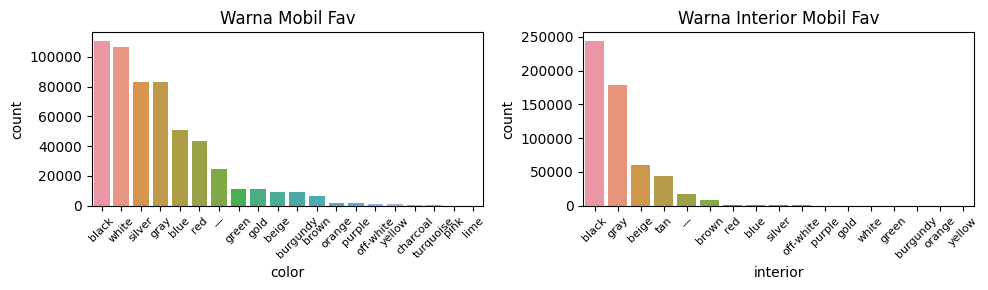

In [ ]:
# Mengelompokan berdasarkan warna mobil dan warna interior
color = dfcar.groupby('color').size().sort_values(ascending= False).reset_index(name= 'count')
interior = dfcar.groupby('interior').size().sort_values(ascending= False).reset_index(name= 'count')

#visualisasi
plt.figure(figsize= (10, 3))

plt.subplot(1,2,1)
sns.barplot(data=color, x='color', y='count')
plt.title('Warna Mobil Fav')
plt.xticks(rotation= 45, size= 8)

plt.subplot(1,2,2)
sns.barplot(data=interior, x='interior', y='count')
plt.title('Warna Interior Mobil Fav')
plt.xticks(rotation= 45, size= 8)
plt.tight_layout()

Dapat terlihat bahwa :
1. Untuk warna mobil dan warna interior mobil paling disukai adalah warna hitam.
2. Terlihat juga bahwa warna interior mobil yang lazim digunakan adalah hitam, abu-abu, beige, dan tan.
3. Terdapat missing value ( - ) pada warna dan interior mobil sehingga perlu dilakukan penanganan pada tahap berikutnya.

### Check Nilai (-) di Fitur Color

In [ ]:
kosong = dfcar[dfcar['color'] == '—']
kosong.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
134,2013,Infiniti,G Sedan,G37 Journey,G Sedan,automatic,jn1cv6ap1dm302069,ca,3.700,21144.000,—,black,nissan infiniti lt,23100,24250,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
154,2013,Infiniti,G Coupe,G37 Sport,G Coupe,automatic,jn1cv6ek5dm900518,ca,4.300,17523.000,—,black,nissan infiniti lt,25600,26500,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
185,2013,Infiniti,G Sedan,G37 Journey,G Sedan,automatic,jn1cv6ap7dm300469,ca,4.100,19957.000,—,beige,nissan infiniti lt,23300,21750,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


Data diatas adalah beberapa baris yang tidak memiliki kejelasan warna pada fitur `color` dan `interior`. Hal ini kemungkinan dapat diisi dengan nilai modus pada masing-masing fitur.

In [ ]:
seller_group = dfcar.groupby('seller').size().sort_values(ascending= False).reset_index(name='count')
seller_group.head(10)

,seller,count
0,nissan-infiniti lt,19693
1,"ford motor credit company,llc",19162
2,the hertz corporation,18299
3,santander consumer,15285
4,avis corporation,12540
5,nissan infiniti lt,9962
6,wells fargo dealer services,8796
7,tdaf remarketing,7209
8,enterprise veh exchange/rental,6853
9,ge fleet services for itself/servicer,6692


## MULTIVARIATE ANALYSIS

### Melihat Korelasi Antar Fitur Numerik

In [ ]:
dfcar.corr()

,year,condition,odometer,mmr,sellingprice
year,1.000,0.551,-0.773,0.597,0.586
condition,0.551,1.000,-0.539,0.485,0.539
odometer,-0.773,-0.539,1.000,-0.588,-0.582
mmr,0.597,0.485,-0.588,1.000,0.984
sellingprice,0.586,0.539,-0.582,0.984,1.000


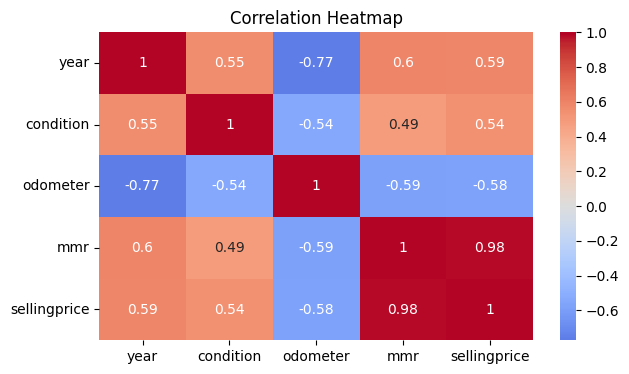

In [ ]:
# Plot korelasi heatmap
corr_matrix = dfcar.corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

1. Korelasi antara 'year' dan 'sellingprice' adalah positif, menunjukkan bahwa semakin baru mobil, semakin tinggi harga jualnya.

2. Kolom 'condition' memiliki korelasi positif dengan 'sellingprice', yang berarti semakin baik kondisi mobil, semakin tinggi harga jualnya.

3. Kolom 'odometer' memiliki korelasi negatif dengan 'sellingprice', menunjukkan bahwa semakin sedikit jarak tempuh, semakin tinggi harga jualnya.

4. Kolom 'mmr' memiliki korelasi positif yang cukup kuat dengan 'sellingprice', menunjukkan bahwa harga jual yang diprediksi oleh MMR memiliki korelasi yang baik dengan harga jual aktual.  

5. Kolom ‘Year’ dan ‘Odometer’ juga menunjukkan korelasi negative yang cukup tinggi, artinya mobil keluaran terbaru memiliki odometer yang cenderung kecil

### Korelasi MMR dan Selling Price

Seperti hasil analisis sebelumnya yang menunjukkan bahwa nilai MMR dan Selling Price memiliki kemiripan yang tinggi, maka kita akan coba memvisualisasikan bagaimana hubungan keduanya.

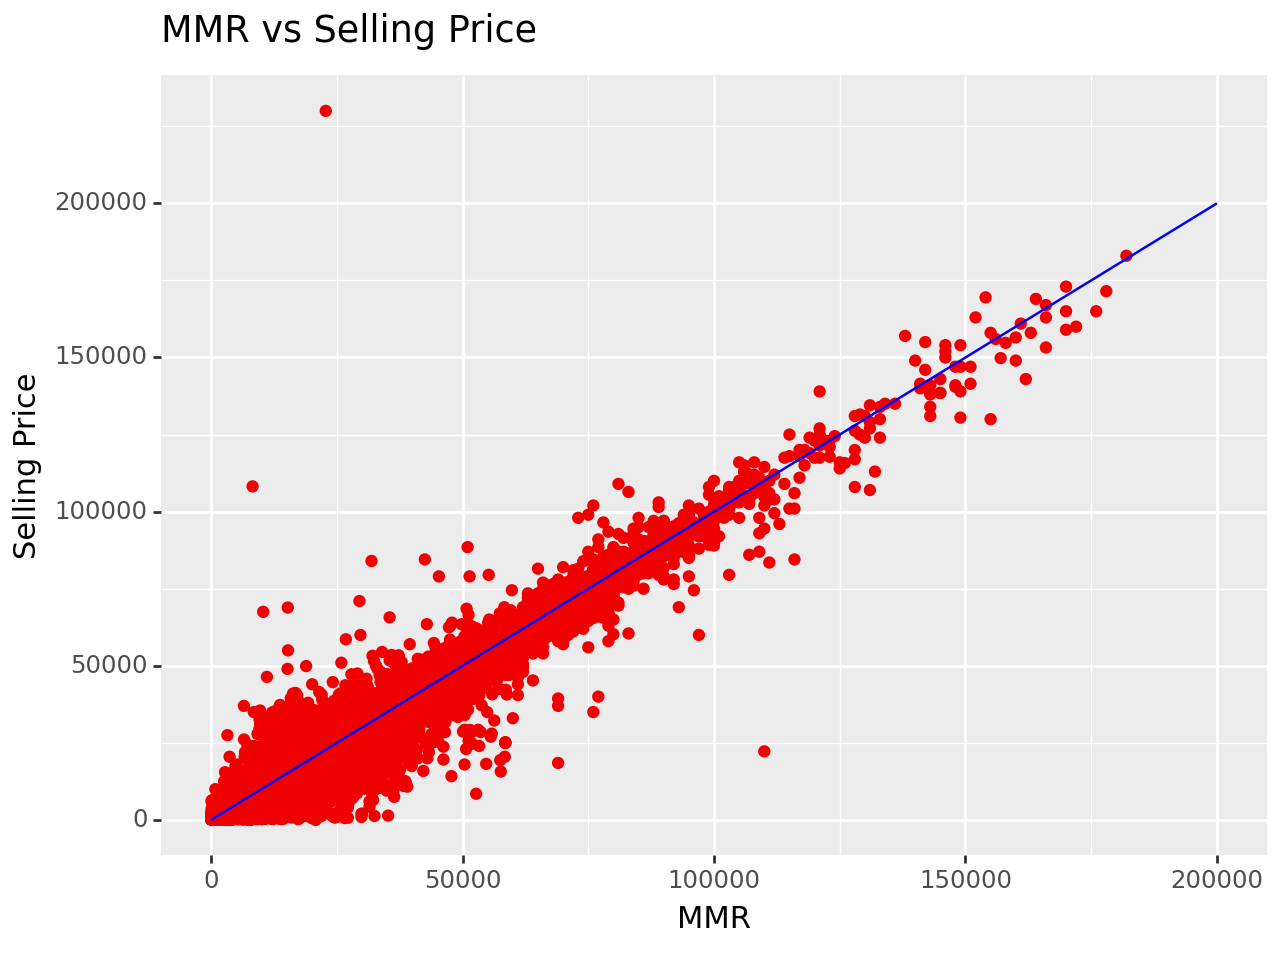

<Figure Size: (640 x 480)>

In [ ]:
from plotnine import *

# Visualisasi MMR dan Selling Price
(ggplot(dfcar)
 + aes(x ='mmr', y ='sellingprice')
 + geom_point(color='#f00000')
 + labs(title='MMR vs Selling Price', x='MMR', y='Selling Price')
 + annotate(geom = "segment", x = 0, xend = 200000, y = 0, yend = 200000, color='blue')
)

Grafik diatas menunjukkan bagaimana persebaran selling price terhadap MMR.  
MMR merupakan singkatan dari Manhiem Market Report yaitu sebuah spesific report yang menjadi indikator wholesale price untuk penjualan kendaraan. Perhitungan harga didasarkan pada lebih dari 10 juta transaksi penjualan selama 13 bulan sebelumnya dengan harga yang tepat oleh penjualan kendaraan nyata di Manheim auction houses.
Sehingga, bisa dikatakan bahwa MMR layak untuk dijadikan acuan harga.

### Korelasi Condition dan MMR Berdasar Tahun

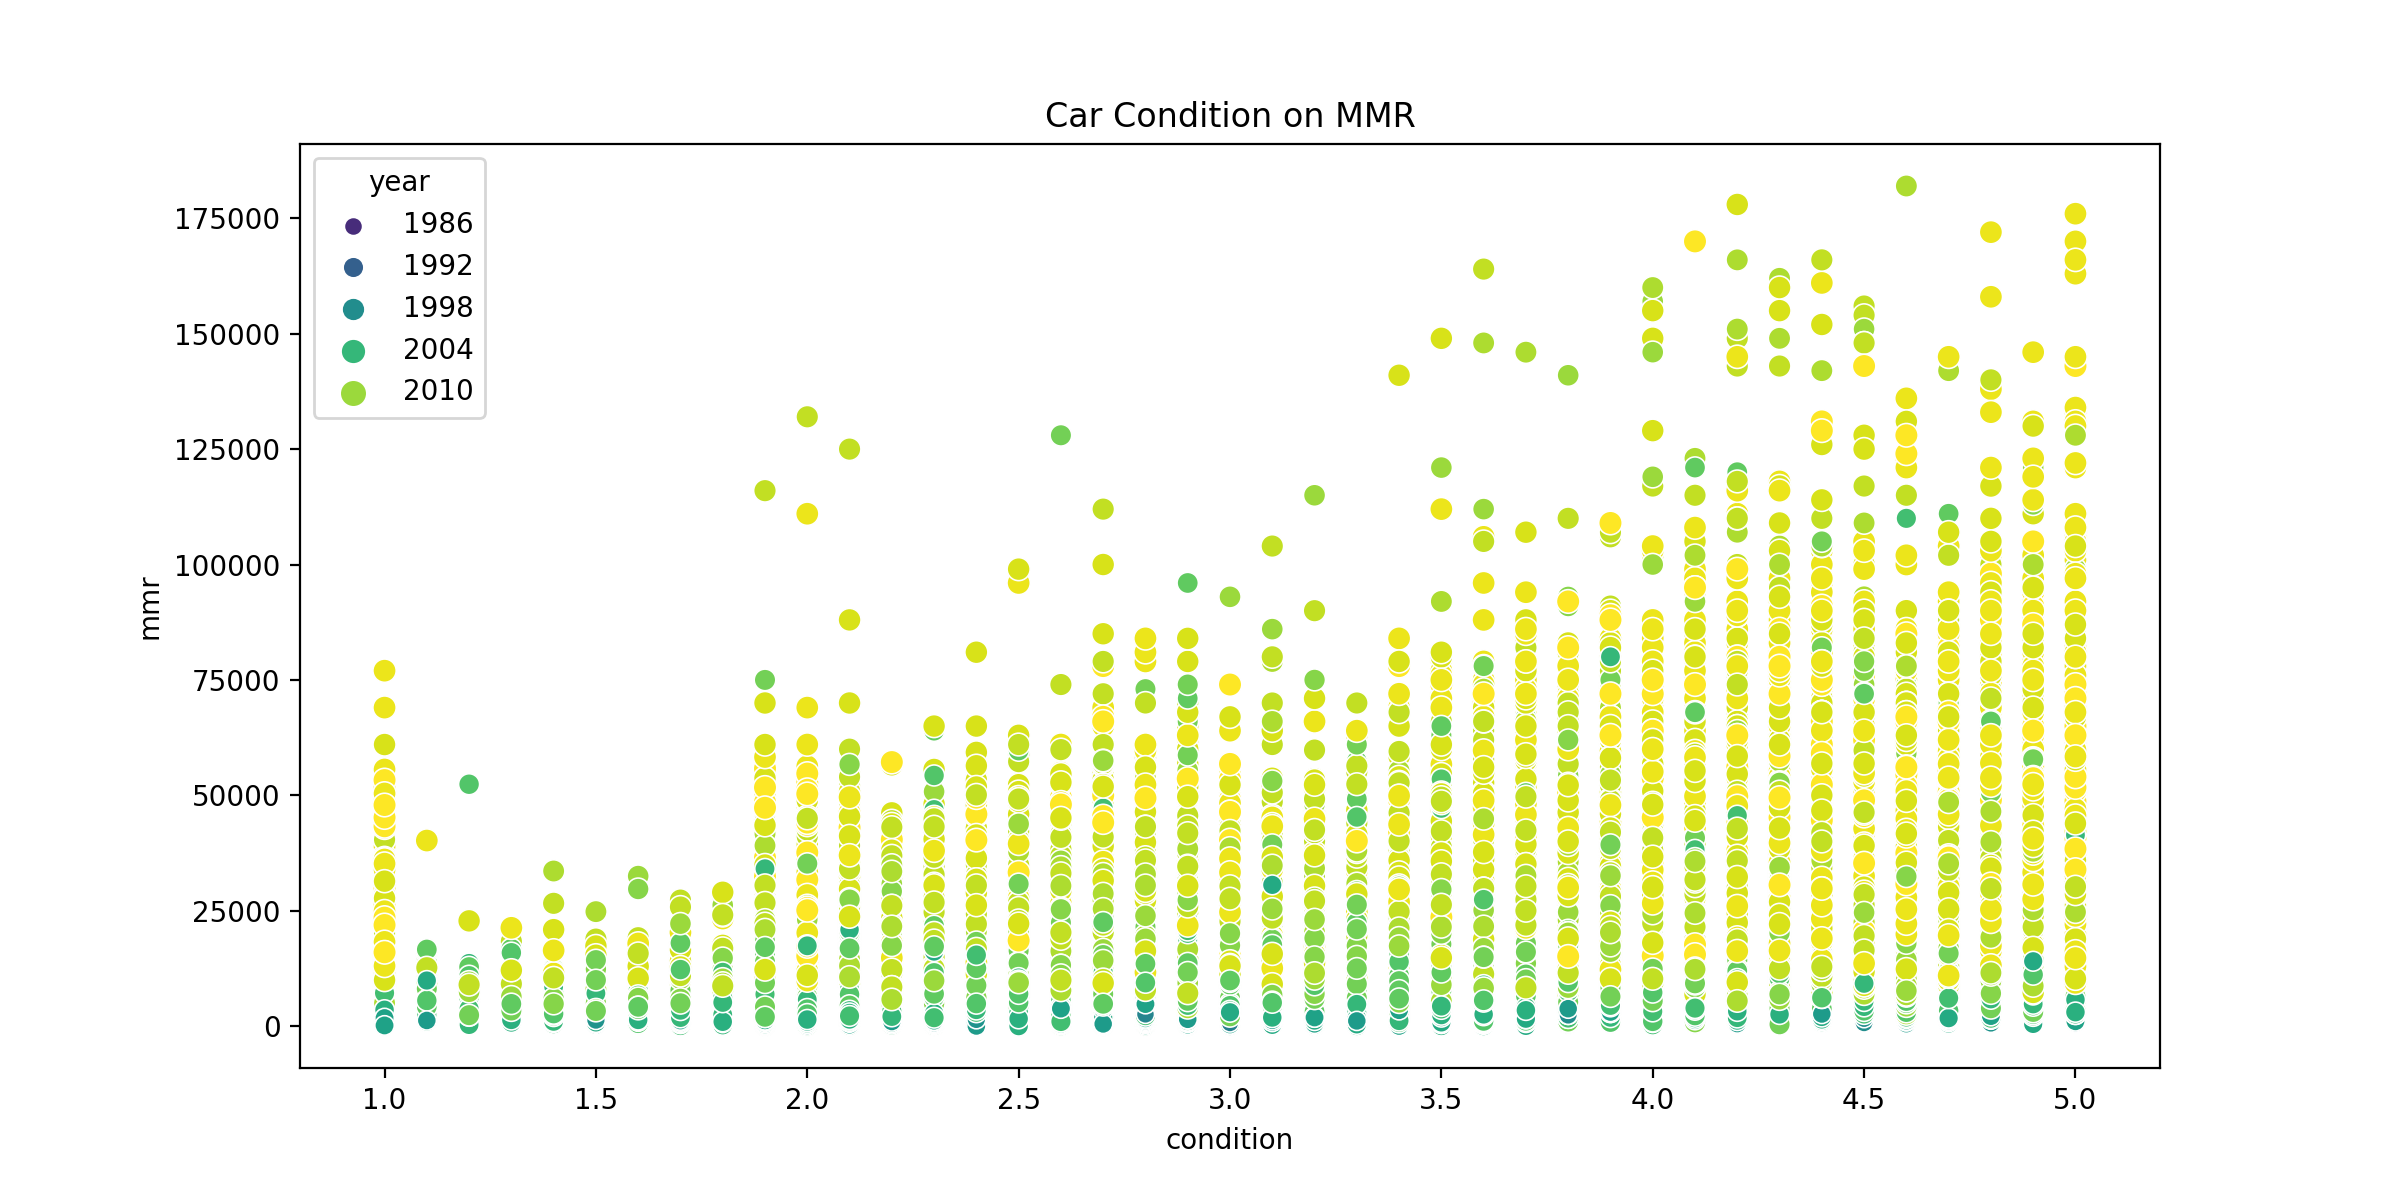

In [ ]:
# Visualisasi Harga Jual Terhadap Kondisi Mobil

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=dfcar, x='condition', y='mmr', hue='year', size= 'year', palette='viridis')
plt.title('Car Condition on MMR')
plt.show()

Dari grafik diatas dapat disimpulkan bahwa pada setiap rentang kondisi mobil dengan mmr yang relatif rendah, terdapat mobil keluaran tahun 2004 keatas. Hal itu bisa mengindikasikan bahwa banyak mobil keluaran tahun 2004 yang dijual bekas.
Selain itu, produksi mobil sejak 2010 mengalami kenaikan pada kondisi nya dan mmr yang semakin tinggi pula. Hal tersebut menunjukkan bahwa mmr memiliki pengaruh kuat terhadap bagus nya kondisi dan tahun produksi mobil.  

### Korelasi State Terhadap MMR

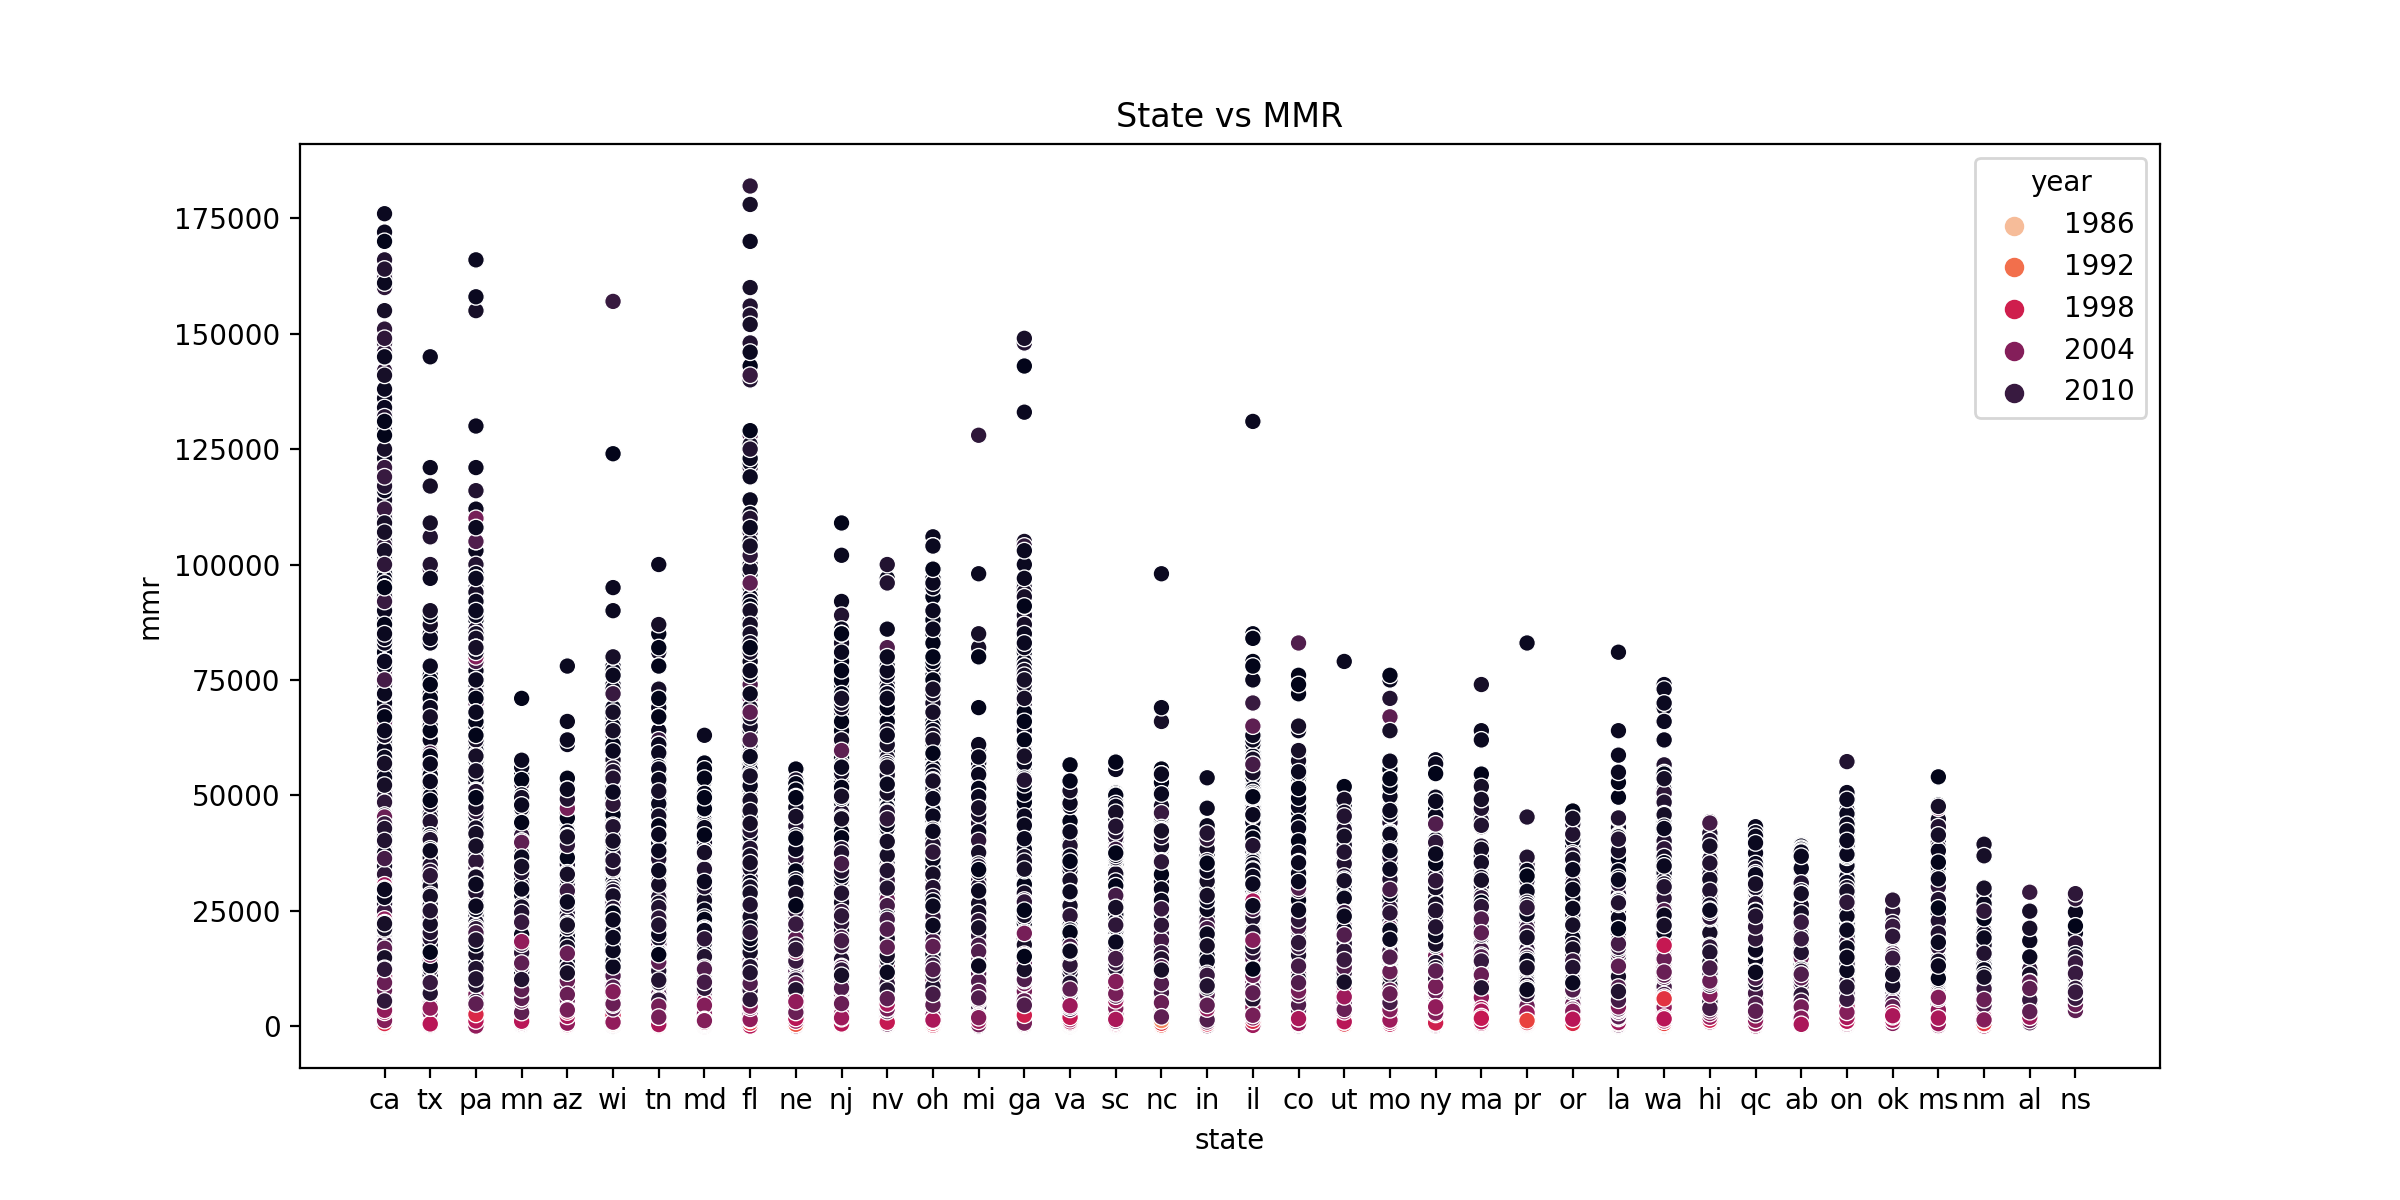

In [ ]:
# Visualisasi State terhadap Jumlah Mobil

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=dfcar, x='state', y='mmr', hue='year', palette='rocket_r')
plt.title('State vs MMR')
plt.show()

Jika dilihat dari hasil visualisasi diatas, terlihat bahwa pembelian mobil terbanyak berasal dari Florida, lalu California, Pennysilvania, dan Ohio. Di state manapun di US, semakin baru tahun produksi mobil maka mmr juga semakin tinggi. Namun, tidak sedikit juga mobil yang diproduksi pada tahun 2004 yang memiliki mmr yang tinggi.  Selain itu, terlihat juga beberapa outlier mmr yang berasal dari beberapa state.

Secara keseluruhan, fitur state tidak menunjukkan korelasi yang signifikan. Hal ini mungkin disebabkan oleh platform online yang memungkinkan pembeli berasalh dari daerah manapun.

----------

# Data Preparation

----

## Data Cleansing

### Dropping

**Duplicated Rows**

Pada tahap Data Exploration sebelumnya, terlihat bahwa tidak ada duplicate rows sehingga tidak perlu penanganan.

**Rows with Extreme Values**

Pada tahap EDA sebelumnya, kita menemukan baris-baris yang memiliki outliers ekstrim dan tidak masuk akal. Maka, di tahap data cleaning ini kita akan menghapus baris-baris tersebut.

In [48]:
# Drop min odo
i_min_odo = dfcar[((dfcar.odometer == 1.000))].index
dfcar = dfcar.drop(i_min_odo)

In [49]:
# Drop max odo
i_max_odo = dfcar[((dfcar.odometer == 999999.000))].index
dfcar = dfcar.drop(i_max_odo)

In [50]:
# Drop min sellingprice
i_min_price = dfcar[((dfcar.sellingprice == 1.000))].index
dfcar = dfcar.drop(i_min_price)

In [51]:
# Drop min mmr
i_min_mmr = dfcar[((dfcar.sellingprice == 25.000))].index
dfcar = dfcar.drop(i_min_mmr)

In [52]:
dfcar.shape

(557421, 16)

**Irrelevant Features**

Beberapa fitur terlihat kurang relevan dan unique value yang dimiliki terlalu luas seperti yang sudah kita analisis sebelumnya. Sehingga diasumsikan bahwa fitur tersebut tidak memiliki pola tertentu. Fitur tersebut adalah `vin`, `sellingprice`, dan `saledate` yang akan dihapus. Alasannya yaitu :  
a. `vin` bukanlah fitur yang menentukan harga mobil karena hanya berfungsi sebagai idetification number dari mobil.  
b. `sellingprice` memiliki korelasi tinggi (0.98) dengan `mmr` (fitur target).  
c. `saledate` tidak menunjukkan faktor yang cukup signifikan dikarenakan waktu yang terlalu luas dan tidak menentu sehingga tidak ada pola khusus yang mempengaruhi harga jual mobil.

In [53]:
dfcar = dfcar.drop(['vin','saledate'], axis=1)
dfcar.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.000,16639.000,white,black,"kia motors america, inc",20500,21500
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.000,9393.000,white,beige,"kia motors america, inc",20800,21500
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,4.500,1331.000,gray,black,financial services remarketing (lease),31900,30000


### Handle Unique Values

Pada beberapa fitur terdapat banyak sekali unique values seperti yang sudah dieksplor sebelumnya. Kita akan menghandle unique values yang tidak seragam tersebut menjadi :  
1. Semua categorical data kecuali saledate akan diubah menjadi lower case untuk mendapatkan value yang bernilai sama.  
2. Nilai " — " pada fitur `color` dan `interior` akan diganti dengan nilai modus, yaitu black.  

In [54]:
def content_consistent(df):
    cols = df.select_dtypes(object).columns.difference(['saledate'])
    df[cols] = df[cols].apply(lambda x: x.str.lower())
    return df

dfcar = content_consistent(dfcar)

In [55]:
dfcar['color'].replace('—','black',inplace=True)

In [56]:
dfcar['interior'].replace('—','black',inplace=True)

In [57]:
cek = dfcar[dfcar['color'] == '—']
cek

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice


In [58]:
# Replace model dan trim dgn menghilangkan special chars

dfcar['model'].replace(to_replace= '[^A-Za-z0-9]+', value= '', regex= True, inplace= True)
dfcar['trim'].replace(to_replace= '[^A-Za-z0-9]+', value= '', regex= True, inplace= True)

In [59]:
# Replace same meaning of value

dfcar['make'].replace('landrover', 'land_rover', inplace= True)
dfcar['make'].replace('mercedes-b', 'mercedes-benz', inplace= True)
dfcar['make'].replace('mercedes', 'mercedes-benz', inplace= True)
dfcar['make'].replace('vw', 'volkswagen', inplace= True)
dfcar['make'].replace('ford tk', 'ford truck', inplace= True)
dfcar['body'].replace('koup', 'coupe', inplace= True)
dfcar['body'].replace('regular-cab', 'regular cab', inplace= True)
dfcar['body'].replace('xtracab', 'extended cab', inplace= True)                  

In [60]:
# Replace seller dengan menghilangkan special chars

dfcar['seller'].replace(to_replace= '[A-Za-z0-9]+', value= '', regex= True, inplace= True)

In [61]:
c = ['make', 'model', 'trim', 'body', 'color', 'interior', 'state', 'seller']

dfcar[c].describe()

,make,model,trim,body,color,interior,state,seller
count,547189,547091,546844,544311,556692,556692,557421,557421
unique,62,839,1854,42,19,16,38,354
top,ford,altima,base,sedan,black,black,fl,
freq,93838,19323,55648,240711,135404,260901,82789,159918


Setelah dilakukan pembersihan data dengan menyamaratakan penulisan string, maka terlihat hasilnya dimana:  
a. `make` yang awalnya 96 kini hanya 62 unique values  
b. `model` yang awalnya 973 kini hanya 839 unique values  
c. `trim` yang awalnya 1975 kini hanya 1854 unique values  
d. `body` yang awalnya 86 kini hanya 42 unique values   
e. `seller` yang awalnya 14264 kini hanya 354 unique values  
f. `color` dan `interior` berkurang 1 nilai dari unique value sebelumnya dikarenakan sudah digantikan oleh nilai modus (black).  
g. `state` adalah satu-satunya yang masih bernilai sama.

### Handle Missing Values

Terdapat 9 fitur yang memiliki Null value, yaitu `make`, `model`, `trim`, `body`, `transmission`, `condition`, `odometer`, `color`, `interior`.

Namun, dikarenakan fitur color dan interior telah dihapus, maka kita hanya perlu meng-handle fitur lainnya.  
1. Seluruh categorical data akan diisi dengan nilai modus.  
2.  `condition` yang memiliki persebaran data yang lumayan normal, maka akan diisi dengan nilai mean.
3. `odometer` yang hanya memiliki 94 null values, kita akan menghapusnya.

In [62]:
mode_value = dfcar.filter(['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']).mode()
cols = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior']

dfcar[cols] = dfcar[cols].fillna(dfcar.mode().iloc[0])

In [63]:
dfcar['condition'] = dfcar['condition'].fillna(dfcar['condition'].mean())

In [64]:
dfcar.dropna(axis=0, inplace=True)
dfcar.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
dtype: int64

In [65]:
df_clean = dfcar.copy()

## Feature Engineering

### Feature Extraction

Dikarenakan pada dataset terdapat banyak fitur kategorikal, maka kita perlu mengubahnya terlebih dahulu menjadi angka. Namun sebelum itu, kita perlu melakukan fitur ekstraksi (feature extraction) untuk melihat pola-pola tertentu yang bisa menyederhanakan proses perubahan fitur nantinya (feature encoding).

#### Is Auto (Ekstraksi Fitur 'transmission')

In [66]:
df_clean['is_auto'] = df_clean['transmission'] == 'automatic'
df_clean.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,is_auto
0,2015,kia,sorento,lx,suv,automatic,ca,5.000,16639.000,white,black,",",20500,21500,True
1,2015,kia,sorento,lx,suv,automatic,ca,5.000,9393.000,white,beige,",",20800,21500,True
2,2014,bmw,3series,328isulev,sedan,automatic,ca,4.500,1331.000,gray,black,(),31900,30000,True


#### Is Above MMR (Ekstraksi Fitur 'sellingprice')  

Karena tujuan kita adalah agar nilai selling price yang baru tidak dibawah MMR, maka kita melabeli data dengan tujuan agar nilai yang lebih besar (1) mewakili nilai yang diatas mmr.

In [67]:
# Kolom yang berisi apakah mobil terjual dibawah MMR atau tidak (0=Tidak, 1=Ya)
df_clean['is_above_mmr'] = df_clean.apply(lambda x: 1 if x.sellingprice > x.mmr else 0, axis=1)
df_clean.head(3)


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice,is_auto,is_above_mmr
0,2015,kia,sorento,lx,suv,automatic,ca,5.000,16639.000,white,black,",",20500,21500,True,1
1,2015,kia,sorento,lx,suv,automatic,ca,5.000,9393.000,white,beige,",",20800,21500,True,1
2,2014,bmw,3series,328isulev,sedan,automatic,ca,4.500,1331.000,gray,black,(),31900,30000,True,0


### Feature Selection

Setelah semua fitur menjadi numerik, selanjutnya kita bisa menghapus kolom kategori awal dan kolom yang tidak diperlukan.

In [69]:
df_clean = df_clean.drop(['transmission'], axis=1)
df_clean.head(3)

,year,make,model,trim,body,state,condition,odometer,color,interior,seller,mmr,sellingprice,is_auto,is_above_mmr
0,2015,kia,sorento,lx,suv,ca,5.000,16639.000,white,black,",",20500,21500,True,1
1,2015,kia,sorento,lx,suv,ca,5.000,9393.000,white,beige,",",20800,21500,True,1
2,2014,bmw,3series,328isulev,sedan,ca,4.500,1331.000,gray,black,(),31900,30000,True,0


### Feature Encoding

In [70]:
df_pre = df_clean

#### Target Encoding

In [72]:
to_encode = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller']

In [74]:
for col in to_encode:
    encoding_map = df_pre.groupby(col)['mmr'].mean().to_dict()
    df_pre[col + '_encoded'] = df_pre[col].map(encoding_map)

In [77]:
df_pre.drop(['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'seller', 'mmr'], axis= 1, inplace= True)

In [78]:
df_pre.columns

Index(['year', 'condition', 'odometer', 'sellingprice', 'is_auto',
       'is_above_mmr', 'make_encoded', 'model_encoded', 'trim_encoded',
       'body_encoded', 'state_encoded', 'color_encoded', 'interior_encoded',
       'seller_encoded'],
      dtype='object')

## Train-Test Split

In [108]:
dfnew = df_pre.copy()

In [109]:
from sklearn.model_selection import train_test_split

x = dfnew.drop('sellingprice', axis=1)
y = dfnew['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Pre-Processing

In [110]:
from sklearn.preprocessing import RobustScaler

# Creating a RobustScaler object
rs = RobustScaler()

# Features to be normalized
feat_scale = dfnew.drop('sellingprice', axis= 1).columns

# Fitting the scaler on data
for col in feat_scale:
    scaler = rs.fit(X_train[[col]])
    X_train[col] = scaler.transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

In [112]:
X_train.head(3)

,year,condition,odometer,is_auto,is_above_mmr,make_encoded,model_encoded,trim_encoded,body_encoded,state_encoded,color_encoded,interior_encoded,seller_encoded
410664,0.167,0.667,-0.422,0.000,0.000,3.356,0.706,1.175,0.000,0.324,0.166,0.494,8.567
203268,-0.333,-0.267,1.379,0.000,1.000,0.648,-0.214,0.000,0.000,0.324,0.166,-0.506,0.000
463788,-0.500,0.400,0.109,0.000,1.000,1.040,-0.202,0.000,0.000,1.759,-0.505,0.000,-0.357


# Modelling and Evaluation

## Modelling

### Linear Regression

In [113]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [114]:
y_pred = regressor.predict(X_test)
y_pred

array([17700.07901086, 23729.28351264,  9637.29955602, ...,
       25708.76141232,  1657.39497789,  2148.70494122])

In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_regression(model, y_pred, X_train, X_test, y_train,  y_test):
    print("MAE: " , mean_absolute_error(y_test, y_pred))
    print("RMSE: " , mean_squared_error(y_test, y_pred, squared=False))
    print('R2 score: ', r2_score(y_test, y_pred))
    print('Coefficients: ', regressor.coef_)
    print('Intercept: ', regressor.intercept_)

eval_regression(regressor, y_pred, X_train, X_test, y_train,  y_test)

MAE:  3030.6911474825656
RMSE:  4474.645124581276
R2 score:  0.7887217874058047
Coefficients:  [ 2401.86249606  1768.89182777 -3199.80235415    35.20154787
  1152.67304392    82.38900432  4441.98124122  1955.4750994
  1266.57596939    84.96594148   228.07348269   427.50876746
   261.53679685]
Intercept:  13234.938624207358


In [116]:
from xgboost import XGBRegressor
# Training the model and displaying the evaluation score

xgb = XGBRegressor(random_state= 0)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [118]:
y_pred = xgb.predict(X_test)
y_pred

array([16520.621 , 24746.617 ,  8122.5405, ..., 25321.234 ,  2131.918 ,
        3505.3167], dtype=float32)

In [119]:
eval_regression(xgb, y_pred, X_train, X_test, y_train,  y_test)

MAE:  1304.5471057652812
RMSE:  2068.544066730192
R2 score:  0.9548490312790127
Coefficients:  [ 2401.86249606  1768.89182777 -3199.80235415    35.20154787
  1152.67304392    82.38900432  4441.98124122  1955.4750994
  1266.57596939    84.96594148   228.07348269   427.50876746
   261.53679685]
Intercept:  13234.938624207358
